# A script for solving the the assignment problem (UPDATED)

**To starts, execute the code cell below:**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from itertools import product
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy


def graph_from_scores(scores):
    """
    Given an array with scores of the assignment problem 
    returns the corresponding weighted networkx graph. 
    Column nodes are labeled C1, C2, etc., row nodes P1, P2, etc.   

    scores:
        A 2-dimensional array with the assignment problem data.

    Returns: 
        A networkx weighted graph object.
    """

    scores = np.array(scores)
    df = pd.DataFrame(scores,
                      index=[f"P{i}" for i in range(1, scores.shape[0] + 1)],
                      columns=[f"C{i}" for i in range(1, scores.shape[1] + 1)])
    B = nx.Graph()  
    B.add_nodes_from([f"C{i}" for i in range(1, scores.shape[1] + 1)])
    B.add_nodes_from([f"P{i}" for i in range(1, scores.shape[0] + 1)])
    for p, c in product(df.index, df.columns):
        if (w := df.at[p, c]) != 0:
            B.add_edge(p, c, weight=w)
    return B, df


def plot_assignment_graph(B, edge_color='k'):
    """
    Plot the graph for an assignment problem. 

    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
        None. 
    """

    plt.figure(figsize=(8, 5))
    node_color = ['lightcoral' if n.startswith("C") else 'lightsteelblue' for n in B.nodes]
    nx.draw_networkx(
        B,
        pos = nx.drawing.layout.bipartite_layout(B, nodes = [n for n in B.nodes if n.startswith("C")]), 
        width = 3,
        node_color=node_color,
        edge_color=edge_color,
        node_size=1000
    )
    plt.show()


def lp_assignment(B):
    """
    Sets up and solves the assignment problem for
    a given weighted bipartite graph.
    
    B:
        A networkx object representing a weighted bipartite graph.
    
    Returns: 
       The data with the linear program solution returned by 
       scipy.optimize.linprog. 
    
    """
    weighted_incidence = nx.incidence_matrix(B, weight="weight").todense()
    edge_weights = weighted_incidence.sum(axis=0)/2
    incidence =  nx.incidence_matrix(B).todense()
    num_slacks = len([n for n in B.nodes if n.startswith("C")])

    c = -edge_weights

    A_ub = incidence[:num_slacks]
    b_ub = np.ones(num_slacks)
    A_eq = incidence[num_slacks:]
    b_eq = np.ones(len(B.nodes) - num_slacks)
    sp = scipy.optimize.linprog(c=c,
                                A_ub=A_ub,
                                b_ub=b_ub,
                                A_eq=A_eq,
                                b_eq=b_eq)
    return sp


def solve_assignment(scores):
    """
    Given an array with scores of the assignment problem, 
    computes the solution of the problem, prints it and
    plots the graph highlighting edges that give the solution.  
    
    Column nodes are labeled C1, C2, etc., row nodes P1, P2, etc.   

    scores:
        A 2-dimensional array with the assignment problem data.

    Returns: 
        None.
    """

    B, scores_df = graph_from_scores(scores)
    print("Scores:")
    display(scores_df)
    sol = lp_assignment(B)
    print("\nLinear program solution:")
    if sol.x is None: 
        print("no solution")
        return None
    print(sol.x)
    edges = np.array([*B.edges(data=True)])
    assignment = edges[sol.x > 0]
    max_score = sum([w["weight"] for c, p, w in assignment])

    print("\nOptimal assignment:")
    for e in assignment: 
        print(e)
    print(f"\nMaximal score: {max_score}")
    edge_color = ['r' if i else 'lightgray' for i in sol.x]
    plot_assignment_graph(B, edge_color=edge_color)

## Using the code to solve the assignment problem

Enter the score table for the assignment problem and run the `solve_assignment` function with the score table as the argument. The output of this function gives the solution of the assignment problem. 

**Example:**

Scores:


,C1,C2,C3,C4,C5,C6,C7
P1,70,90,0,75,55,0,60
P2,40,95,85,0,0,80,0
P3,50,0,75,0,70,0,65
P4,0,0,60,80,0,35,0
P5,0,75,0,70,0,35,20



Linear program solution:
[ 1.  0.  0. -0.  0.  1. -0.  1.  0.  0.  1. -0.  0.  0.  1.  0.  0.  0.
  0.  0.]

Optimal assignment:
['C1' 'P1' {'weight': 70}]
['C2' 'P5' {'weight': 75}]
['C3' 'P3' {'weight': 75}]
['C4' 'P4' {'weight': 80}]
['C6' 'P2' {'weight': 80}]

Maximal score: 380


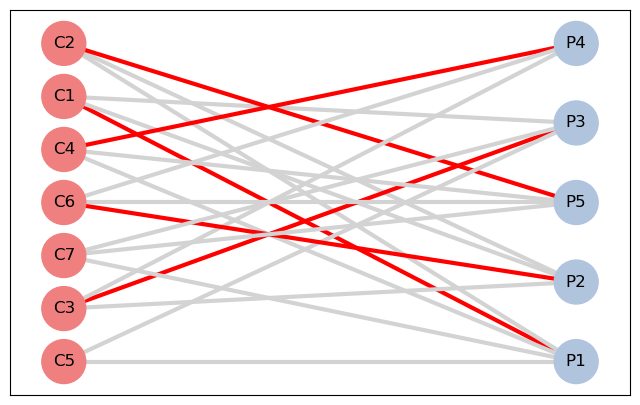

In [3]:
scores = [[70, 90,  0, 75, 55,  0, 60],
          [40, 95, 85,  0,  0, 80,  0],
          [50,  0, 75,  0, 70,  0, 65],
          [ 0,  0, 60, 80,  0, 35,  0],
          [0,  75,  0, 70,  0, 35, 20]]


solve_assignment(scores)

**Note.** The function `solve_assignment` computes the assignment that maximizes the sum of scores. In order to minimize the sum of scores, multiply all 
scores by -1 and then use this function.

In [4]:
scores = [[19, 2, 3, 7, 8, 18],
          [2, 19, 20, 18, 3, 7],
          [3, 18, 19, 19, 2, 8],
          [6, 3, 2, 20, 19, 7],
          [7, 8, 7, 3, 18, 2],
          [3, 6, 7, 7, 4, 20]
         ]

scores = np.array(scores)*(-1)

Scores:


,C1,C2,C3,C4,C5,C6
P1,-19,-2,-3,-7,-8,-18
P2,-2,-19,-20,-18,-3,-7
P3,-3,-18,-19,-19,-2,-8
P4,-6,-3,-2,-20,-19,-7
P5,-7,-8,-7,-3,-18,-2
P6,-3,-6,-7,-7,-4,-20



Linear program solution:
[ 0.  1.  0.  0.  0. -0.  1.  0.  0.  0.  0. -0.  0.  0.  0.  1.  0. -0.
  0.  0.  0.  0.  0.  1.  0. -0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]

Optimal assignment:
['C1' 'P2' {'weight': -2}]
['C2' 'P1' {'weight': -2}]
['C3' 'P4' {'weight': -2}]
['C4' 'P6' {'weight': -7}]
['C5' 'P3' {'weight': -2}]
['C6' 'P5' {'weight': -2}]

Maximal score: -17


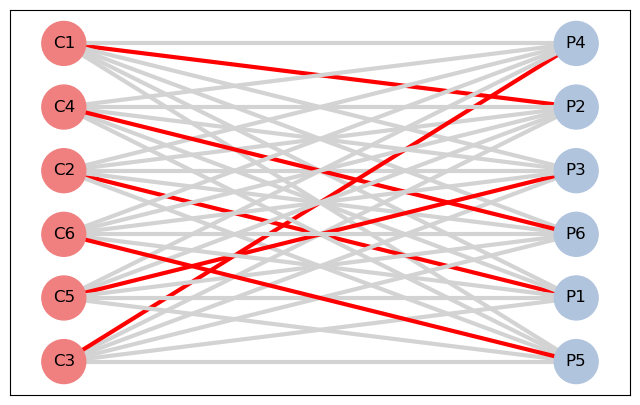

In [5]:
solve_assignment(scores)